# Example II: Tracking already loaded data

Sometimes data needs to be processed first. For example if derived variables like density potential temperature are applied to the tracking, or data needs to be remapped first. In this scenario you would create the dataset yourself, rather then letting the code load the data, and apply the tracking on the dataset. In this example we are going to process satellite based rainfall estimates from the [CMORPH product](https://www.cpc.ncep.noaa.gov/products/janowiak/cmorph_description.html) over the Indonesian archipelago.

Before we get started we import all modules that are needed to apply the tracking:

In [1]:
from IPython.display import HTML
from tintx import RunDirectory, config
import xarray as xr
import pandas as pd
from pathlib import Path
import os
%matplotlib inline

Cmorph is globally available from 60°S - 60°N. In this example we are going to open the dataset and select the sub-region that suits the Indonesian archipelago.

In [2]:
data_files = Path(os.environ["DATA_FILES"])
files = [str(f) for f in data_files.rglob('CMORPH*.nc')]

dset = xr.open_mfdataset(sorted(files), combine='by_coords').sel(
    lon=slice(100, 160), lat=slice(-13, 13))
dset

<xarray.Dataset>
Dimensions:      (time: 48, nv: 2, lat: 357, lon: 825)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:30:00
  * lat          (lat) float64 -12.95 -12.88 -12.81 -12.73 ... 12.81 12.88 12.95
  * lon          (lon) float64 100.0 100.1 100.1 100.2 ... 159.8 159.9 160.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float64 dask.array<chunksize=(2, 357, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float64 dask.array<chunksize=(2, 825, 2), meta=np.ndarray>
    cmorph       (time, lat, lon) float32 dask.array<chunksize=(2, 357, 825), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.072771376
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.072756669
    geospatial_lon_units:       degrees_east

In [3]:
dset = dset.rename({"cmorph": "precip"})

We can now simply create a `RunDicrectory` object by directly initialising the class. Since the `time`, `lon` and `lat` dimensions already have the default names we don't have to pass the `x_coord`, `y_coord` or `time_coord` keywords:

In [4]:
RD = RunDirectory(dset, "precip")
RD.data

<xarray.Dataset>
Dimensions:      (time: 48, nv: 2, lat: 357, lon: 825)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:30:00
  * lat          (lat) float64 -12.95 -12.88 -12.81 -12.73 ... 12.81 12.88 12.95
  * lon          (lon) float64 100.0 100.1 100.1 100.2 ... 159.8 159.9 160.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float64 dask.array<chunksize=(2, 357, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float64 dask.array<chunksize=(2, 825, 2), meta=np.ndarray>
    precip       (time, lat, lon) float32 dask.array<chunksize=(2, 357, 825), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.072771376
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.072756669
    geospatial_lon_units:       degrees_east

### The tuning parameters
To apply the actual tracking algorithm we can use the `get_tracks` method. The algorithm can be tuned by passing the values for the tuning parameters. See also the [tuning parameter section](api.html#tracking-parameter-guide) of the docs:

In [5]:
print(config.__doc__)


Tracking tuning parameters
--------------------------

The following parameter can be set to tune the cell tracking algorithm

* field_thresh : units of 'field' attribute, default: 32
    The threshold used for object detection. Detected objects are connected
    pixels above this threshold.
* iso_thresh : units of 'field' attribute, default: 4
    Used in isolated cell classification. Isolated cells must not be connected
    to any other cell by contiguous pixels above this threshold.
* iso_smooth : pixels, default: 4
    Gaussian smoothing parameter in peak detection preprocessing. See
    single_max in tint.objects.
* min_size : square kilometers, default: 8
    The minimum size threshold in pixels for an object to be detected.
* search_margin : meters, default: 250
    The radius of the search box around the predicted object center.
* flow_margin : meters, default: 750
    The margin size around the object extent on which to perform phase
    correlation.
* max_disparity : float, 

Once the object has been created the cells can be tracked and plotted like in [Example I](I_Tracking_data_from_files.html) (with a little more tuning):

In [6]:
num_cells = RD.get_tracks(min_size=8,
                          field_thresh=3, 
                          iso_thresh=10,
                          iso_smoth=10,
                          search_margin=8750,
                          flow_margin=1750,
                          max_disparity=999,
                          max_flow_mag=5000,
                          max_shift_disp=1000,
                         )
print(f"Number of storm cells found: {num_cells}")

Tracking:   0%|          | 0/47 [00:00<?, ?it/s]

Number of storm cells found: 344


### Accessing the track data
Like in the previous [example I](I_Tracking_data_from_files.html) the actual tracking data is stored in a multi-index [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) and can be accessed via the `tracks` property:

In [7]:
RD.tracks

time   grid_x   grid_y       lon      lat  area  \
scan uid                                                                   
0    0    2020-01-25 00:00:00  623.304    2.087  145.3314 -12.8078    23   
     1    2020-01-25 00:00:00  819.826   13.765  159.6645 -11.9345   115   
     2    2020-01-25 00:00:00  620.889   22.111  145.1859 -11.3523     9   
     3    2020-01-25 00:00:00  617.827   29.442  144.9677 -10.8429    52   
     4    2020-01-25 00:00:00  594.500   48.400  143.2215  -9.4603    10   
...                       ...      ...      ...       ...      ...   ...   
47   322  2020-01-25 23:30:00  463.125  257.875  133.6904   5.8217     8   
     323  2020-01-25 23:30:00  363.900  271.100  126.4875   6.7677    10   
     272  2020-01-25 23:30:00  364.314  279.451  126.4875   7.3499    51   
     324  2020-01-25 23:30:00  375.667  292.216  127.3605   8.2959    51   
     325  2020-01-25 23:30:00  363.475  294.220  126.4147   8.4415    59   

            max       mean  isolated  
scan uid                              
0    0     5.07   4.811738      True  
     1     6.40   4.352870      True  
     2     3.41   3.383333      True  
     3     5.61   4.107116      True  
     4     3.68   3.420000      True  
...         ...        ...       ...  
47   322   5.97   5.950000      True  
     323  14.00   6.623000      True  
     272  91.00  21.292744      True  
     324   9.54   4.426471      True  
     325  16.90   6.375593      True  

[2732 rows x 9 columns]

After each tracking the `RunDirectory` class creates a so called hash of the resulting `DataFrame` and saves the tuning parameters for this specific tracking. The next time you call the tracking method the previous tuning parameters are noted and set automatically. This means that in the above example the `filed_thresh` and `min_size` parameters are automatically set for the next tracking.

## Displaying the results
Data visualisation works just like in the previous example. For example we can plot the storm trajectories:

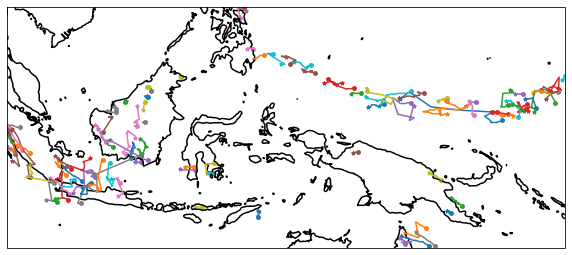

In [8]:
ax = RD.plot_trajectories(plot_style={"resolution": "10m", "ms": 15, "lw": 1.5},
                          label=False,
                          mintrace=10,
)

## Saving the tracks for later analysis
Again, for a later analysis the results can be saved using the `save_tracks` method. This will save the tracks `DataFrame` to a hdf5 table format. hdf5 is the format of choice as it can save additional metadata to like the tracking parameters.

In [9]:
RD.save_tracks("/tmp/tint_tracks_sat.h5")

## Loading the tracked files

Loading the files is somewhat more tricky since we haven't used the `from_files` class method to load the data set and the `RunDirectory` class has no information about the data files that were opened to create the dataset.

Still we can load a tracked dataset from a hdf5 tracking file by providing the dataset the tracking is based on. In our case this is the cmorph dataset we opened:

In [10]:
RD = RunDirectory.from_dataframe("/tmp/tint_tracks_sat.h5", dataset=dset)
RD.data

<xarray.Dataset>
Dimensions:      (time: 48, nv: 2, lat: 357, lon: 825)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:30:00
  * lat          (lat) float64 -12.95 -12.88 -12.81 -12.73 ... 12.81 12.88 12.95
  * lon          (lon) float64 100.0 100.1 100.1 100.2 ... 159.8 159.9 160.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float64 dask.array<chunksize=(2, 357, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float64 dask.array<chunksize=(2, 825, 2), meta=np.ndarray>
    precip       (time, lat, lon) float32 dask.array<chunksize=(2, 357, 825), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.072771376
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.072756669
    geospatial_lon_units:       degrees_east

In [11]:
RD.tracks

time   grid_x   grid_y       lon      lat  area  \
scan uid                                                                   
0    0    2020-01-25 00:00:00  623.304    2.087  145.3314 -12.8078    23   
     1    2020-01-25 00:00:00  819.826   13.765  159.6645 -11.9345   115   
     2    2020-01-25 00:00:00  620.889   22.111  145.1859 -11.3523     9   
     3    2020-01-25 00:00:00  617.827   29.442  144.9677 -10.8429    52   
     4    2020-01-25 00:00:00  594.500   48.400  143.2215  -9.4603    10   
...                       ...      ...      ...       ...      ...   ...   
47   322  2020-01-25 23:30:00  463.125  257.875  133.6904   5.8217     8   
     323  2020-01-25 23:30:00  363.900  271.100  126.4875   6.7677    10   
     272  2020-01-25 23:30:00  364.314  279.451  126.4875   7.3499    51   
     324  2020-01-25 23:30:00  375.667  292.216  127.3605   8.2959    51   
     325  2020-01-25 23:30:00  363.475  294.220  126.4147   8.4415    59   

            max       mean  isolated  
scan uid                              
0    0     5.07   4.811738      True  
     1     6.40   4.352870      True  
     2     3.41   3.383333      True  
     3     5.61   4.107116      True  
     4     3.68   3.420000      True  
...         ...        ...       ...  
47   322   5.97   5.950000      True  
     323  14.00   6.623000      True  
     272  91.00  21.292744      True  
     324   9.54   4.426471      True  
     325  16.90   6.375593      True  

[2732 rows x 9 columns]

After loading the track data we can inquire the tuning parameters that had been applied to create the tracks:

In [12]:
RD.get_parameters()

{'ISO_THRESH': 10.0,
 'FIELD_THRESH': 3.0,
 'ISO_SMOOTH': 4.0,
 'MIN_SIZE': 8.0,
 'SEARCH_MARGIN': 8750.0,
 'FLOW_MARGIN': 1750.0,
 'MAX_DISPARITY': 999.0,
 'MAX_FLOW_MAG': 5000.0,
 'MAX_SHIFT_DISP': 1000.0,
 'GS_ALT': 1500.0,
 'ISO_SMOTH': 10.0}

This concludes the second tutorial, in [the next one](III_Using_the_command_line_interface.html) we will explore the application of the tracking algorithm via the Command Line Interface.